# Manipulating fMRI data and computing a connectome

## Loading the data

For this tutorial, we will use the data provided by the `nilrean.datasets` module.
We first download some fMRI data from 1 subject

In [57]:
from nilearn import datasets
from nilearn import image as nimg

import warnings
warnings.filterwarnings('ignore')

data_dir = None # change this variable with the path where you want nilearn to download
                # the data, if you leave None, the default will be '~/nilearn_data'
    
# Loading the functional datasets
data = datasets.fetch_development_fmri(n_subjects=1, data_dir=data_dir)

# you can use the .keys() method to check what's in the dataset
data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [ ]:
# We can check the description of the dataset to know what we're dealing with 
print(data.description.decode("utf-8")) # the .decode("utf-8") is used because the description is a bytestring

In [2]:
# data.func contains the paths to the Nifti files (the files containing fMRI data)
fmri_filepath = data.func[0]
print(fmri_filepath)

C:\Users\davide_momi/nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [3]:
# We can load a Nifti file with the nibabel library
import nibabel as nib

fmri_img = nib.load(fmri_filepath)
print(fmri_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (50, 59, 50, 168)
affine: 
[[   4.    0.    0.  -96.]
 [   0.    4.    0. -132.]
 [   0.    0.    4.  -78.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  50  59  50 168   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 4. 4. 4. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : align

So this is a `Nifti1Image` object which contains 3 things :
* some data of shape (50, 59, 50, 168)
* an affine array that defines the spatial orientation and scale of the data
* a header, containing more information about the data format

Note that the data is a 4D array. The last dimension is the time, so we have 168 volumes, and from the 5th value of the pixdim array in the header we can see that the t_r is 1s, so we have a file that represents 168s of scanning. 

For each time point we have a 3D array that contains the voxels. But not all these voxels correspond to the brain.

#### What fMRI actually represents

We've represented fMRI as a snapshot of MR signal over multiple timepoints. This is a useful way of understanding the organization of fMRI, however it isn't typically how we think about the data when we analyze fMRI data. fMRI is typically thought of as time-series data. We can think of each voxel (x,y,z coordinate) as having a time-series of length T. The length T represents the number of volumes/timepoints in the data. Let's pick an example voxel and examine its time-series using ```func_mni_img.slicer```:

In [28]:
single_vox = fmri_img.slicer[25:26,45:46,30:31,:].get_data()
single_vox.shape

(1, 1, 1, 168)

As you can see we have 1 element in (x,y,z) dimension representing a single voxel. In addition, we have 168 elements in the fourth dimension. In totality, this means we have a single voxel with 152 timepoints. Dealing with 4 dimensional arrays are difficult to work with - since we have a single element across the first 3 dimensions we can squish this down to a 1 dimensional array with 168 time-points. We no longer need the first 3 spatial dimensions since we’re only looking at one voxel and don’t need (x,y,z) anymore:

In [29]:
single_vox = single_vox.flatten()
single_vox.shape

(168,)

Here we’ve pulled out a voxel at a specific coordinate at every single time-point. This voxel has a single value for each timepoint and therefore is a time-series. We can visualize this time-series signal by using a standard python plotting library. We won’t go into too much detail about python plotting, the intuition about what the data looks like is what is most important:

First let’s import the standard python plotting library ```matplotlib```:

Text(0, 0.5, 'Signal Value')

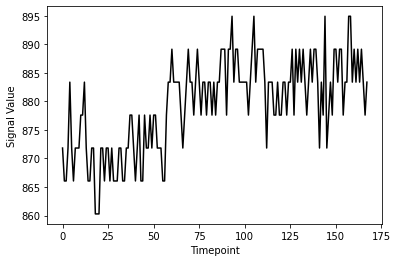

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Make an array counting from 0 --> 168, this will be our x-axis
x_axis = np.arange(0, single_vox.shape[0])

# Plot our x and y data, the 'k' just specifies the line color to be black
plt.plot(x_axis, single_vox, 'k')

# Label our axes
plt.xlabel('Timepoint')
plt.ylabel('Signal Value')

The fmri_img we have imported is a ```nibabel.nifti1.Nifti1Image``` object. We can access to the data using the ```get_fdata()``` method

In [17]:
# let's get the data array 
fmri_data = fmri_img.get_fdata()
fmri_data.shape

(50, 59, 50, 168)

We can choose a voxel (for example the one with coordinates 25, 30, 25) and plot its time series :

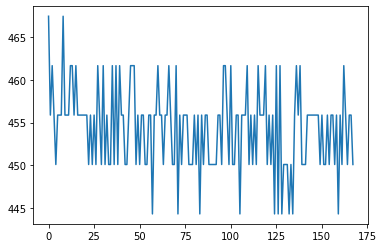

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fmri_data[25,30,25])

We can also plot a slice of our brain for a time point as an image, for example a transversal slice for the first time point and z=25 : 

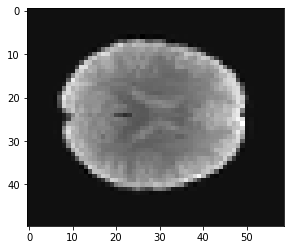

In [6]:
plt.imshow(fmri_data[:,:,25,0], cmap='gray')

Here all the black pixels in our image are voxels present in our `fmri_data` array but not containing any brain. Thus we want to exclude all these empty voxels just to keep the ones containing brain data. To do that we're gonna use a **masker**. 

## Masking the data

The masker not only removes the background voxels, but it can also regress out the confounds if you provide them.

In short, the confounds are external sources of signal you want to remove, such as the movement of the head. Regressing out the confounds means removing the part of the signal correlated to the sources of noise. For example we can remove the part of the signal that correlates with the head motion because we consider this part of signal to be only artefacts caused by the movements and not relevant for brain activity. 

Confounds handling is in reality more complicated than that, if you want to learn more you can check the [fMRIprep documentation](https://fmriprep.org/en/stable/outputs.html#confounds).

In [37]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker()
masked_data = masker.fit_transform(fmri_filepath, confounds=data.confounds)
masked_data.shape

(168, 32504)

Now you see that our array has a different shape, we have our time dimension first with still 168 time points, but for each time point, instead of a 3D volume, we have a 1D array. 

Also note that we kept 32,504 voxels, when whe had a total of 50*59*50 = 147,500, so we got rid of a lot of empty voxels. That is good, but the downside is that we lost the spatial information of where these voxels are in the brain. But don't worry because the masker remembers it. If we want to recover this information and turn back our 1D arrays into 3D spatial ones we can uste the `makser.inverse_transform` method.

For example if we want to threshold our fMRI data by the mean and then plot ther result we can do it this way :

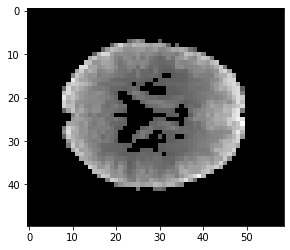

In [38]:
thresholded_masked_data = masked_data * (masked_data > masked_data.mean())

thresholded_img = masker.inverse_transform(thresholded_masked_data)

plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')

**NOTE**: In this example we instantiated a `NiftiMasker` without providing any argument, 
however depending on the data used, we might want to use specific strategies to remove the
background voxels, and we can ask the masker to do some complementrary processing such as 
standardizing the data, deterending it or resampleing it. In real-life use cases you should carefully 
choose the arguments to provide to the `NiftiMasker`. These arguments are explained in 
the [nilearn documentation](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html).

## Using an atlas


Having removed the empty voxels is great, and we could directly compute a connectome on the masked data,
but it would create a 32,504 by 32,504 matrix, which would be a bit hard to analyse.

An easier way to manipulate the data would be to use an atlas, that defines region of interest (ROIs). We could create our own atlas by clustering the voxels, but hopefully nilearn provides ready-made atlases, let's load one.

### Retrieving the Atlas

For this tutorial we’ll be using a set of parcellation from [Schaefer et al. 2018](https://pubmed.ncbi.nlm.nih.gov/28981612/). This atlas was generated from fMRI data from 1000 healthy control participants.

To retrieve the Schaefer atlas we’ll use the `fetch_atlas_*` family of functions provided for by nilearn.datasets and download it into a local directory:

In [113]:
parcel_dir = '../resources/rois/'
atlas_schaefer_2018 = datasets.fetch_atlas_schaefer_2018(n_rois=200, 
                                                         yeo_networks=7, 
                                                         resolution_mm=2, 
                                                         data_dir=parcel_dir)

In [114]:
atlas_schaefer_2018.keys()

dict_keys(['maps', 'labels', 'description'])

The map key in `atlas_schaefer_2018` is a `.nii.gz` image which contains a 3D NIFTI volume with a label for a given (x,y,z) voxel. Since these images are 3D volumes (sort of like structural images), we can view them using nilearn’s plotting utilities:

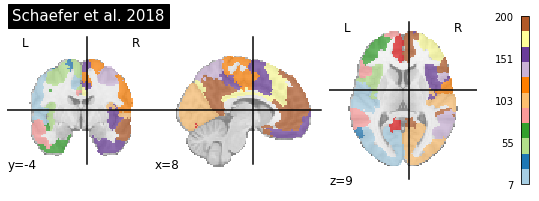

In [115]:
from nilearn import plotting as nplot

#Define where to slice the image
cut_coords = (8, -4, 9)
#Show a colorbar
colorbar=True
#Color scheme to show when viewing image
cmap='Paired'

#Plot the parcellation schema referred to by atlas_schaefer_2018
nplot.plot_roi(atlas_schaefer_2018['maps'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='Schaefer et al. 2018')

You’ll notice that the colour bar on the right shows the number of labels in each atlas and which colour corresponds to which network

The 7 Network parcellation includes the following networks:

1. Visual
2. Somatosensory
3. Dorsal Attention
4. Ventral Attention
5. Limbic
6. Frontoparietal
7. Default


The parcel areas labelled with 0 are background voxels not associated with a particular network.

#### Resampling the Atlas

Let’s import the NIFTI file of the atlas so that we can work with it later:

In [125]:
schaefer_labels = nib.load(atlas_schaefer_2018['maps'])

Our goal is to match the parcellation atlas dimensions to our functional file so that we can use it to extract the mean time series of each parcel region. Using Nilearn’s resampling capabilities match the dimensions of the atlas file to the functional file First let’s pick our functional file. Atlases are typically defined in standard space so we will use the MNI152NLin2009cAsym version of the functional file. 


First examine the size of both files, if they match we are done:

In [126]:
print("Size of functional image:", fmri_img.shape)
print("Size of atlas image:", schaefer_labels.shape)

Size of functional image: (50, 59, 50, 168)
Size of atlas image: (91, 109, 91)


Looks like they don't match. To resolve this, we can use `nimg.resample_to_img` to resize the atlas image to match that of the functional image. Think about what kind of interpolation we'd like to use. Recall that the atlas contains integer values (i.e 0, 1, 2, 3,...), we do not want any in-between values!

In [127]:
from nilearn import image as nimg

resampled_schaefer = nimg.resample_to_img(schaefer_labels,
                                          fmri_img,
                                          interpolation = 'nearest')

Let's see what the resampled atlas looks like overlayed on a slice of our NifTI file


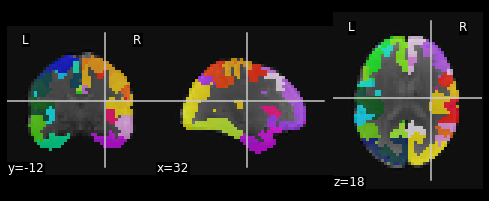

In [128]:
nplot.plot_roi(resampled_schaefer, fmri_img.slicer[:, :, :, 54])


### Visualizing ROIs


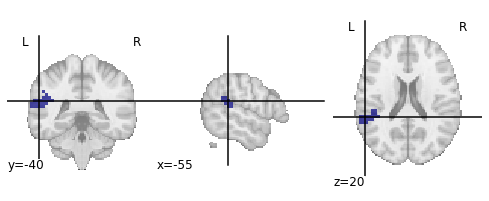

In [129]:
roi = 44

# Make a mask for ROI 44
roi_mask_44 = nimg.math_img('a == 44', a=resampled_schaefer)  

# Visualize ROI
nplot.plot_roi(roi_mask_44)

We our variable `atlas_schaefer_2018` which includes the names of the ROIs in `labels` and the nifti volume in`maps` (see line below)

In [132]:
atlas_schaefer_2018.keys()

dict_keys(['maps', 'labels', 'description'])

To apply the atlas on our data, we can once again use a masker, but this time a `NiftiLabelsMasker`.

In [135]:
from nilearn import input_data


masker = input_data.NiftiLabelsMasker(labels_img=resampled_schaefer,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      detrend=True,
                                     low_pass = 0.08,
                                     high_pass = 0.009,
                                     t_r=2)

data_in_atlas = masker.fit_transform(fmri_filepath, confounds=data.confounds)
data_in_atlas.shape

(168, 200)

We can plot the time series in a ROI (for example the 5th one) :

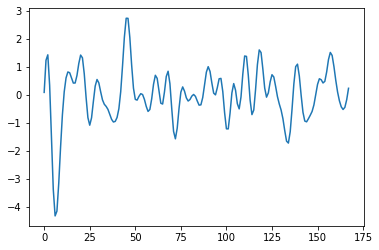

In [136]:
plt.plot(data_in_atlas[:,4])

**Note**: Depending on the type of atlas you use, you might have to use different kinds of masker. Here we have probabilistic overlapping regions, so we use a `NiftiMapsMasker`, but if we had non-overlapping regions, we would use a `NiftiLabelsMasker`.

## Connectome

Let's compute and plot a correlation matrix !

In [174]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
labels = list(atlas['ROI Name'])
coordinates = np.vstack((atlas['R'], atlas['A'], atlas['S'])).T

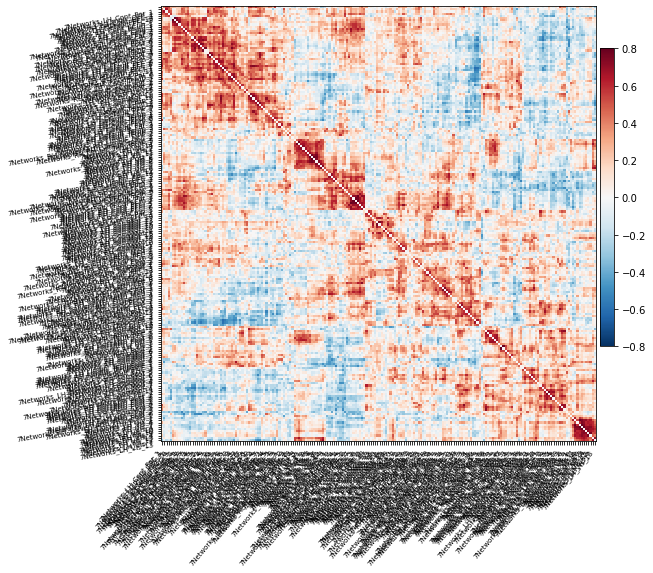

In [152]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

## Plotting

Earlier we simply plotted a slice of our brain with matplotlib. It works and it is a fine way to check your data array. However for more complex or fancy plots, nilearn comes with a lot of handy tools in its `nilearn.plotting` module. Here are a few examples.

* To view a 3D NiftiImage object, the `view_img` functions makes it easy to interactively go through the slices.


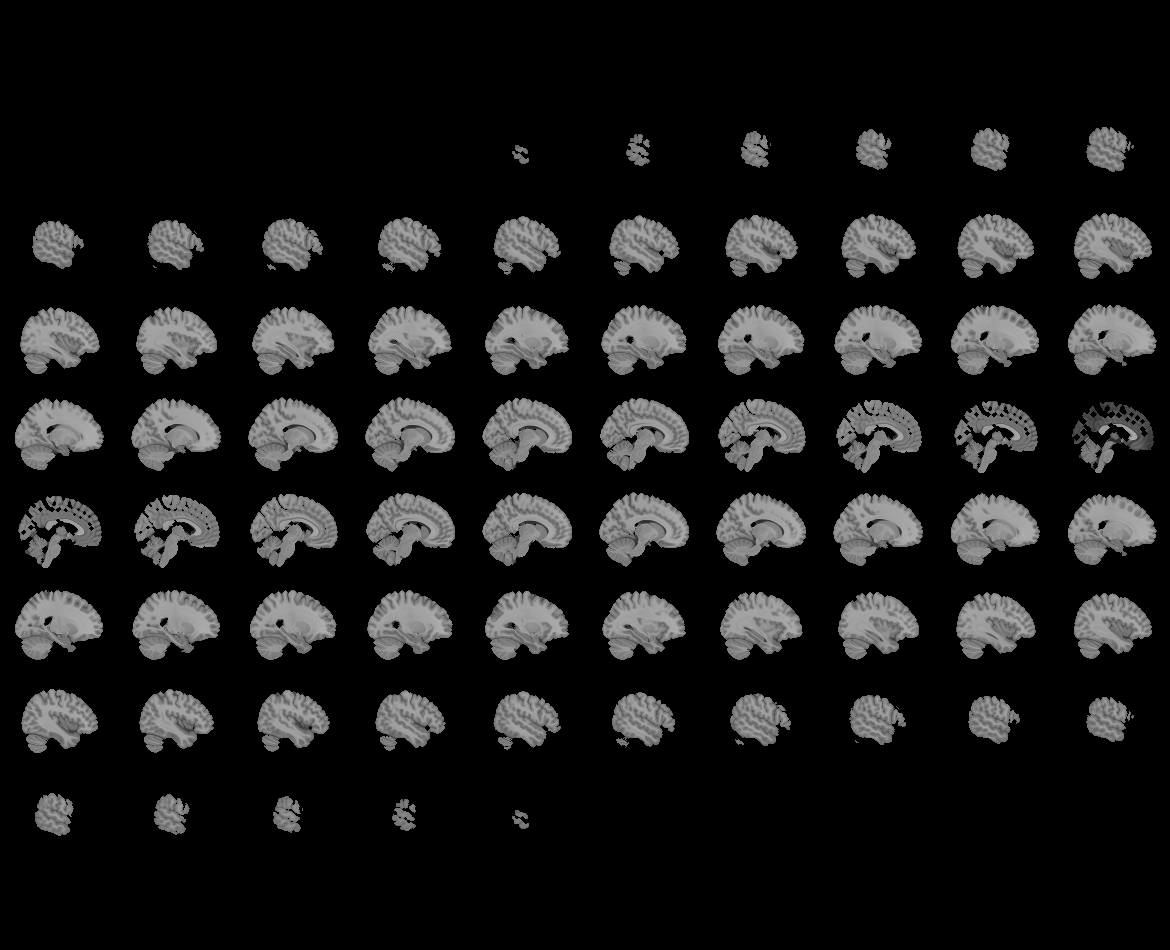
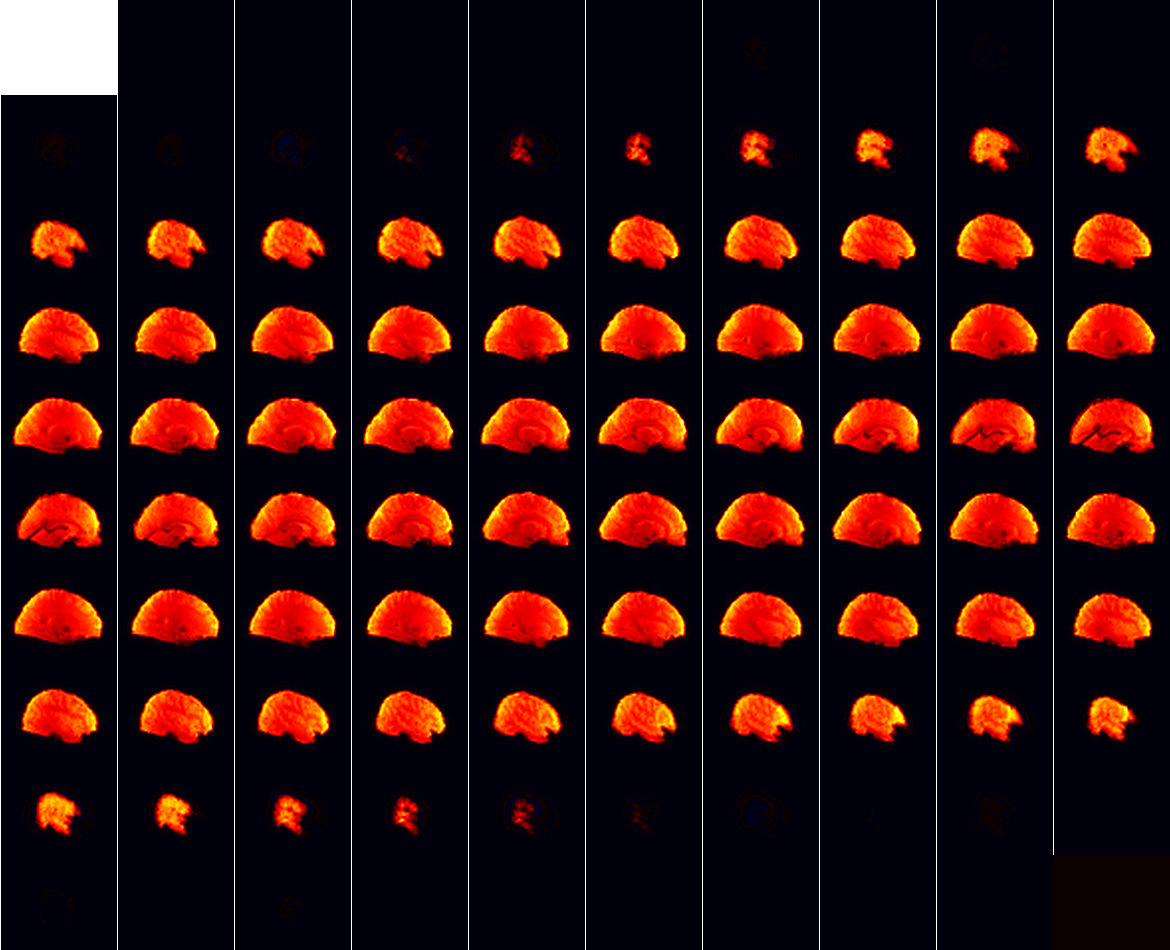

In [142]:
from nilearn.plotting import view_img

# Since our fmri_img is a 4D NiftiImage, we need to generate a 3D one.
# One way of doing that is averaging our volumes on the time axis 
# with the mean_img function.
from nilearn.image.image import mean_img

fmri_img_mean = mean_img(fmri_img)
view_img(fmri_img_mean)

* To display the graph corresponding to a connectome, you can use `view_connectome`.

In [175]:
plotting.view_connectome(correlation_matrix, coordinates, edge_threshold="90%")

To discover more ways of generating super cool visuals of brains, check the [nilearn plotting documentation](https://nilearn.github.io/plotting/index.html).

# Exercises

## 1. Of the importance of confounds

* Generate a correlation matrix with the same data, but this time without using the confounds when masking.

How does that impact the correlation matrix ?
Why do you think it affects the matrix this way ?

* Plot the obtained connectome in 3D using `nilearn.plotting.view_connectome` (check [the doc](https://nilearn.github.io/modules/generated/nilearn.plotting.view_connectome.html) to know how to use it).

## 2. Visualizing the atlas and a specific time point

* Use `view_img` to visualize the 5th ROI of the atlas. (Hint: use the atlas masker to inverse transform an array with 1 at the index 4 and 0 every where else.)

* Use `plotting.plot_prob_atlas` to show all the ROIs with filled contours. (Hint: check the nilearn documentation to see how to use `plotting.plot_prob_atlas`).
* Earlier we used `view_img` to plot the mean volume of our `fmri_img` data because `view_img` doesn't accept 4D images but only 3D ones. Find a way to generate a 3D Nifti image with the 84th time point in `fmri_img` and plot it with `view_img`.

## 3. Seed-based connectivity

* Using the information provided in [this nilearn tutorial](https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html), plot the seed-to-voxel correlation map of our fmri_img for the seed of coordinates (-16, -74, 7) and with a sphere mask of radius of size 10. 

In [ ]:
vis_coords = [(-16, -74, 7)]